<h1>Hawkes Split Distribution Multivariate</h1><br>
Similar to 'Hawkes Split Distribution' except using multivariate kernels. The data is split into two categories (one for each variable in the process) based on the direction of travel (to or from the given client)

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



<h2>Setup</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tick.plot import plot_hawkes_kernels
import os
from HelperFunctions import MultiHist
from TickHelper import TrainEM, SimEM, SavedModel

c:\users\ricard grace\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#convenience variables
sec = 1000000000
split_time = 0.00025

#tweakable parameters
data_csv = 'data.csv' #the raw data
c_id = 4 #client (dataset to use)
#the maximum interarrival time to model. This will change based on the dataset.
#Generally set it high enough to capture all the interarrivals. for client 4, 36 seconds is good enough
k_time = 36
#how many intervals to consider when training each model
#Will train 1 model with each kernel size (warning: larger k_sizes vastly increase training time)
k_sizes = [18, 36, 72, 180, 360, 720]
sim_time = 240000 #time frame to simulate points up to in seconds

#files
#save model = f"HawkesEMMult_{k_sizes[i]}_RHS_model_c{c_id}.npz" ###if you want to change this you will need to modify two places in the evaluation section
#save dist = f"HawkesEMMult_{k_sizes[i]}_RHS_dist_c{c_id}.npz" ###if you want to change this you will need to modify it in evaluation (in one place)
dist_folder = "saved_dist"
model_folder = "saved_model"

<h2>Data Loading</h2>

In [3]:
#load raw data
X = pd.read_csv(data_csv)

#get the marks
marks = X[X.client_id == c_id].from_ds

#split into processes based on direction
d0 = np.ediff1d(X[(X.client_id == c_id) & (X.from_ds == 0)].time.apply(lambda x:x/sec))
d1 = np.ediff1d(X[(X.client_id == c_id) & (X.from_ds == 1)].time.apply(lambda x:x/sec))
t0 = np.cumsum(d0[d0 > split_time])
t1 = np.cumsum(d1[d1 > split_time])

<h2>Training</h2>

In [4]:
learners = []
for k_size in k_sizes:
    em_learner = TrainEM([t0,t1], k_time=k_time, k_size=k_size)
    learners.append(em_learner)

Launching the solver HawkesEM...
  n_iter  | rel_baseline | rel_kernel
        0 |     8.25e-01 |   8.54e-01
       10 |     1.82e-02 |   1.24e-02
       20 |     3.44e-03 |   1.02e-03
       30 |     9.91e-04 |   7.16e-04
       40 |     5.62e-04 |   5.36e-04
       50 |     4.10e-04 |   3.79e-04
       60 |     2.79e-04 |   2.61e-04
       70 |     1.76e-04 |   1.79e-04
       80 |     1.15e-04 |   1.25e-04
       90 |     8.44e-05 |   9.05e-05
      100 |     6.98e-05 |   6.71e-05
      110 |     6.03e-05 |   5.10e-05
      120 |     5.19e-05 |   3.95e-05
      130 |     4.40e-05 |   3.11e-05
      140 |     3.66e-05 |   2.47e-05
      150 |     3.00e-05 |   1.99e-05
      160 |     2.43e-05 |   1.62e-05
      170 |     1.94e-05 |   1.34e-05
      180 |     1.55e-05 |   1.13e-05
      190 |     1.23e-05 |   9.65e-06
      200 |     9.76e-06 |   8.38e-06
Done solving using HawkesEM in 172.58935403823853 seconds
Launching the solver HawkesEM...
  n_iter  | rel_baseline | rel_kernel
  

<h2>Evaluation</h2>

<h3>Model Kernels</h3><br>
Contains graphs of the kernels created through training

k_size=18
kernel_baseline=[0.01602926 0.12540178]


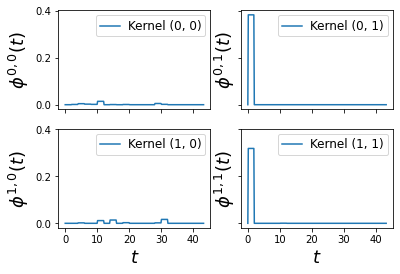

k_size=36
kernel_baseline=[0.013069   0.10757233]


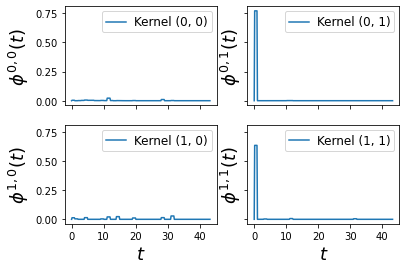

k_size=72
kernel_baseline=[0.01079895 0.0839145 ]


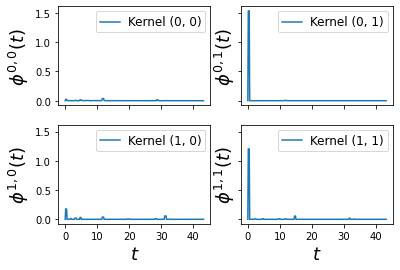

k_size=180
kernel_baseline=[0.00829794 0.06843971]


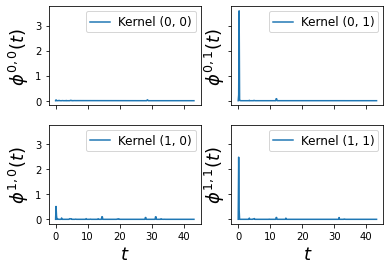

k_size=360
kernel_baseline=[0.0075042  0.06744893]


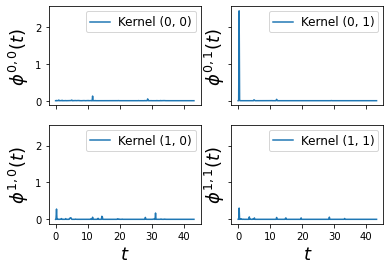

k_size=720
kernel_baseline=[0.00608873 0.04585095]


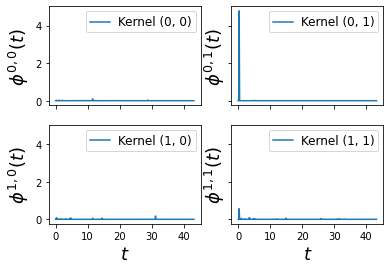

In [5]:
for i, learner in enumerate(learners):
    #save
    smodel = SavedModel(learner, k_time, k_sizes[i])
    fname = os.path.join(model_folder, f"HawkesEMMulti_{k_sizes[i]}_RHS_model_c{c_id}.npz")
    smodel.Save(fname)
    
    #display
    print(f"k_size={k_sizes[i]}")
    print(f"kernel_baseline={smodel.baseline}")
    plot_hawkes_kernels(learner)
    plt.show()

<h3>Model Simulation and Statistics</h3><br>
Models are simulated to generate new points and statistics computed on those points

In [6]:
for size in k_sizes:
    #load the model
    fname = os.path.join(model_folder, f"HawkesEMMulti_{size}_RHS_model_c{c_id}.npz")
    smodel = np.load(fname, allow_pickle=True)['savedmodel'].item()
    
    #simulate points
    synth_deltas = [np.ediff1d(series) for series in SimEM(smodel, time=sim_time)]
    synth_deltas = [series[series < smodel.k_time] for series in synth_deltas]
    merged = np.concatenate(synth_deltas) #merge for generating statistics
    
    #statistics
    print(f"=== Kernel Size: {smodel.k_size} ===")
    print(f"Total points: {len(merged)}")
    print(f"Intensity Baseline: {smodel.baseline}")
    print(f"mean: {np.mean(merged)}")
    print(f"median: {np.median(merged)}")
    print(f"std: {np.std(merged)}")
    print(f"min: {np.min(merged)}")
    print(f"max: {np.max(merged)}")
    print("===========================")
    print()
    
    #save the simulation
    fname = os.path.join(dist_folder, f"HawkesEMMulti_{size}_RHS_dist_c{c_id}.npz")
    np.savez(fname, deltas=synth_deltas)

=== Kernel Size: 18 ===
Total points: 69883
Intensity Baseline: [0.01602926 0.12540178]
mean: 5.776478206844862
median: 2.633149559085723
std: 7.193820519095228
min: 0.00014383328380063176
max: 35.99907847979921

=== Kernel Size: 36 ===
Total points: 61583
Intensity Baseline: [0.013069   0.10757233]
mean: 6.154888972982875
median: 3.0143048270401778
std: 7.671123742102854
min: 3.99486452806741e-06
max: 35.99605525196239

=== Kernel Size: 72 ===
Total points: 19809
Intensity Baseline: [0.01079895 0.0839145 ]
mean: 10.383903842860843
median: 7.929467205527544
std: 8.73094848809409
min: 0.00025098085461650044
max: 35.99876988567485

=== Kernel Size: 180 ===
Total points: 15622
Intensity Baseline: [0.00829794 0.06843971]
mean: 11.497651617076048
median: 9.204027509196749
std: 9.190476613973457
min: 0.0012338520027697086
max: 35.999336220207624

=== Kernel Size: 360 ===
Total points: 15191
Intensity Baseline: [0.0075042  0.06744893]
mean: 11.452361424059628
median: 9.13432753241068
std: 9.1